In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm
from scipy.spatial import distance

In [2]:
path = "../data/external/visium_annotated_cell2location.h5ad"
mapped = sc.read_h5ad(path)
mapped.var_names_make_unique()
mapped_data = mapped.obs

/data/olga/anaconda3/envs/torch_gnn/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
cts = ['B-cells',
       'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid',
       'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells']

In [4]:
rep1_ct = pd.DataFrame(mapped.obsm["xe_rep1_celltype_major"],columns = cts, index = mapped.obs.index)

In [5]:
c2l = mapped_data[cts]

In [6]:
c2l = c2l.T/c2l.sum(axis = 1)

In [7]:
c2l = c2l.T

In [8]:
c2l

,B-cells,CAFs,Cancer Epithelial,Endothelial,Myeloid,Normal Epithelial,PVL,Plasmablasts,T-cells
spot_id,,,,,,,,,
2,0.003458,0.052252,0.562138,0.049299,0.093895,0.156521,0.034151,0.003896,0.044389
4,0.004355,0.556858,0.368153,0.024826,0.020650,0.002213,0.011894,0.002783,0.008267
6,0.102264,0.432504,0.000208,0.001781,0.100521,0.000112,0.006558,0.217767,0.138285
7,0.000376,0.008549,0.973980,0.001790,0.000818,0.012667,0.000272,0.000481,0.001068
15,0.000062,0.000376,0.960428,0.000558,0.000459,0.037280,0.000307,0.000266,0.000263
...,...,...,...,...,...,...,...,...,...
4986,0.004164,0.587646,0.309524,0.008845,0.009375,0.001711,0.023903,0.024276,0.030556
4987,0.004391,0.708061,0.000802,0.234963,0.023106,0.000163,0.003012,0.004676,0.020826
4988,0.038137,0.087142,0.057917,0.062026,0.225248,0.004964,0.009049,0.024539,0.490978


In [9]:
error_rate_c2l = ((rep1_ct - c2l)**2).sum(axis = 1)

In [10]:
path = "../data/raw/visium/"
visium = sc.read_visium(path, genome=None, count_file='CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5',
                        library_id=None, load_images=True, source_image_path=None)
visium.var_names_make_unique()

/data/olga/anaconda3/envs/torch_gnn/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
coor_int = [[int(x[0]),int(x[1])] for x in visium.obsm["spatial"]]
visium.obsm["spatial"] = np.array(coor_int)

In [12]:
visium.obs["spot_id"] = [str(x) for x in range(visium.shape[0])]

In [13]:
visium.obs["spot"] = visium.obs.index

In [14]:
visium.obs.set_index("spot_id", inplace=True)

In [15]:
visium = visium[c2l.index]

In [16]:
visium.obs["error_rate_c2l"] = error_rate_c2l

/tmp/ipykernel_19392/226862368.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  visium.obs["error_rate_c2l"] = error_rate_c2l


[<Axes: title={'center': 'error_rate_c2l'}, xlabel='spatial1', ylabel='spatial2'>]

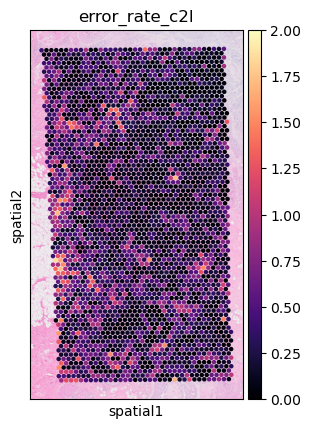

In [17]:
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color="error_rate_c2l",
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax=2,
                  show=False
                 )

In [18]:
spacetree = sc.read_h5ad("../data/interim/visium_annotated_gat.h5ad")

In [19]:
spacetree = spacetree[visium.obs.spot]

In [23]:
spacetree.obs.columns

Index(['in_tissue', 'array_row', 'array_col', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'diploid',
       'Normal Epithelial', 'CAFs', 'T.cells', 'Endothelial',
       'Cancer Epithelial', 'Myeloid', 'PVL', 'Plasmablasts', 'B.cells',
       'clone', 'cell_type', 'degree1', 'degree2', 'sc', 'self', 'umap1',
       'umap2'],
      dtype='object')

In [24]:
spacetree.obs.columns = ['in_tissue', 'array_row', 'array_col', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'diploid',
       'Normal Epithelial', 'CAFs', 'T-cells', 'Endothelial',
       'Cancer Epithelial', 'Myeloid', 'PVL', 'Plasmablasts', 'B-cells',
       'clone', 'cell_type', 'degree1', 'degree2', 'sc', 'self', 'umap1',
       'umap2']

In [25]:
st_res = spacetree.obs[cts]

In [26]:
error_rate_st = ((rep1_ct.values - st_res.values)**2).sum(axis = 1)

In [27]:
error_rate_st

array([0.34734015, 0.26131813, 0.24385693, ..., 0.36301919, 0.13186351,
       0.53870864])

In [28]:
visium.obs["error_rate_st"] = error_rate_st

[<Axes: title={'center': 'error_rate_st'}, xlabel='spatial1', ylabel='spatial2'>]

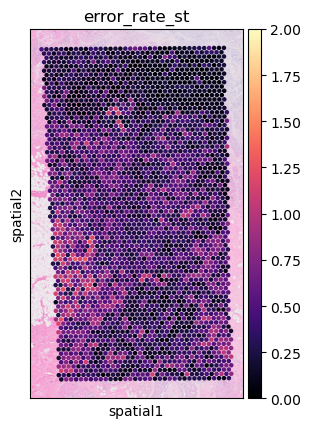

In [29]:
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color="error_rate_st",
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax=2,
                  show=False
                 )

In [30]:
tangram_res = pd.read_csv("../data/interim/tangram.csv", index_col = 0)

In [31]:
tangram_res

,Myeloid,Cancer Epithelial,PVL,Normal Epithelial,T.cells,CAFs,Endothelial,Unnamed: 8,B.cells,Plasmablasts
CTCGTGTCTTGGCCGC-1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
ATCTGCCGTCTACAGC-1,1.0,4.0,1.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0
CGACTTCACTCGGCAT-1,6.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0
AATGGCATAGTATCAT-1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
TCCTGATAAGTGCCGT-1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...
ATAGTCCGCCGTTGGC-1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ACCATTAGATCGTGGC-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AAGGTTCATGCGGTGC-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ATCCGTTATCGAAGGC-1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [32]:
tangram_res = tangram_res.T/tangram_res.sum(axis = 1)

In [33]:
tangram_res = tangram_res.T

In [34]:
tangram_res.columns = ['Myeloid', 'Cancer Epithelial', 'PVL', 'Normal Epithelial', 'T-cells',
       'CAFs', 'Endothelial', 'Unnamed: 8', 'B-cells', 'Plasmablasts']

In [35]:
tangram_res = tangram_res[cts]

In [36]:
shared_spots = list(set(tangram_res.index).intersection(visium.obs.spot))

In [37]:
len(shared_spots)

2484

In [38]:
error_rate_tangram = ((rep1_ct.loc[visium.obs[visium.obs.spot.isin(shared_spots)].index].values - tangram_res.loc[shared_spots].values)**2).sum(axis = 1)

In [39]:
error_rate_tangram = pd.DataFrame(error_rate_tangram,index = shared_spots, columns = ["error_rate_tangram"])

In [40]:
visium.obs = visium.obs.join(error_rate_tangram, on = "spot")

[<Axes: title={'center': 'error_rate_tangram'}, xlabel='spatial1', ylabel='spatial2'>]

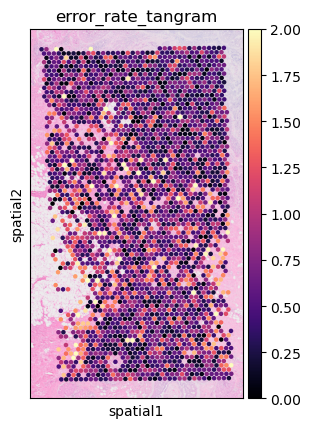

In [41]:
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color="error_rate_tangram",
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax=2,
                  show=False
                 )

In [42]:
dot = pd.read_csv("../data/external/dot_out.csv", index_col = 0)

In [43]:
dot = dot.T/dot.sum(axis = 1)

In [44]:
dot = dot.T

In [45]:
dot.columns = ['Myeloid', 'Cancer Epithelial', 'PVL', 'Normal Epithelial', 'T-cells',
       'CAFs', 'Endothelial', 'B-cells', 'Plasmablasts']

In [46]:
dot =dot.loc[visium.obs.spot]

In [47]:
error_rate_dot = ((rep1_ct.values - dot.values)**2).sum(axis = 1)

In [48]:
visium.obs["error_rate_dot"] = error_rate_dot

[<Axes: title={'center': 'error_rate_dot'}, xlabel='spatial1', ylabel='spatial2'>]

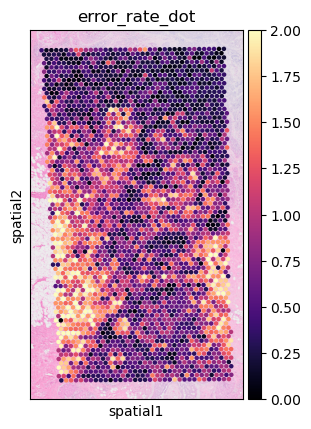

In [49]:
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color="error_rate_dot",
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax=2,
                  show=False
                 )

In [50]:
card = pd.read_csv("../data/external/card_results.csv", index_col = 0)

In [51]:
card = card.T/card.sum(axis = 1)

In [52]:
card = card.T

In [53]:
card.columns

Index(['Myeloid', 'Cancer Epithelial', 'PVL', 'Normal Epithelial', 'T.cells',
       'CAFs', 'Endothelial', 'B.cells', 'Plasmablasts'],
      dtype='object')

In [54]:
card.columns = ['Myeloid', 'Cancer Epithelial', 'PVL', 'Normal Epithelial', 'T-cells',
       'CAFs', 'Endothelial', 'B-cells', 'Plasmablasts']

In [55]:
card.index = [x.replace(".","-") for x in card.index]

In [56]:
card

,Myeloid,Cancer Epithelial,PVL,Normal Epithelial,T-cells,CAFs,Endothelial,B-cells,Plasmablasts
AACACCTACTATCGAA-1,0.049504,6.303505e-05,0.003286,0.000370,0.001129,0.924391,0.020789,0.000268,0.000200
AACACGTGCATCGCAC-1,0.119029,1.706432e-04,0.003771,0.001037,0.003365,0.815710,0.007281,0.000346,0.049291
AACACTTGGCAAGGAA-1,0.091875,4.741714e-03,0.133516,0.056247,0.023312,0.460149,0.220955,0.004659,0.004544
AACAGGAAGAGCATAG-1,0.233113,1.598278e-03,0.024090,0.009534,0.043867,0.539891,0.105267,0.006509,0.036132
AACAGGATTCATAGTT-1,0.090697,3.728047e-03,0.003886,0.004572,0.001693,0.883171,0.011277,0.000181,0.000795
...,...,...,...,...,...,...,...,...,...
TGTTGGAACGAGGTCA-1,0.196955,2.861092e-05,0.003019,0.000141,0.000266,0.772832,0.026615,0.000047,0.000096
TGTTGGAAGCTCGGTA-1,0.271026,3.465381e-03,0.030740,0.018231,0.208864,0.229988,0.161459,0.042278,0.033948
TGTTGGATGGACTTCT-1,0.229300,2.670089e-01,0.044383,0.142099,0.062468,0.102321,0.080712,0.041648,0.030059
TGTTGGCCAGACCTAC-1,0.051128,4.357566e-04,0.004996,0.001725,0.006116,0.927189,0.005039,0.001901,0.001471


In [57]:
shared = list(set(card.index).intersection(visium.obs.spot))

In [58]:
card =card.loc[shared]


In [59]:
error_rate_card= ((rep1_ct.loc[visium.obs[visium.obs.spot.isin(shared)].index].values - card.values)**2).sum(axis = 1)

In [60]:
error_rate_card = pd.DataFrame(error_rate_card, index = card.index, columns = ["error_rate_card"])

In [61]:
visium.obs = visium.obs.join(error_rate_card, on = "spot")

[<Axes: title={'center': 'error_rate_card'}, xlabel='spatial1', ylabel='spatial2'>]

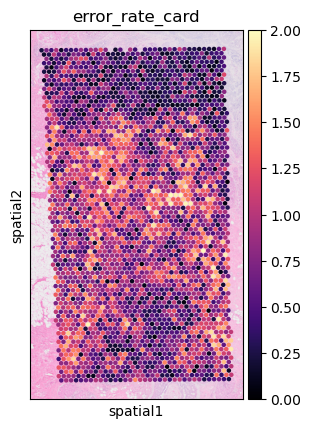

In [62]:
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color="error_rate_card",
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax=2,
                  show=False
                 )

In [65]:
visium.obs

,in_tissue,array_row,array_col,spot,error_rate_c2l,error_rate_st,error_rate_tangram,error_rate_dot,error_rate_card
spot_id,,,,,,,,,
2,1,47,71,AACACTTGGCAAGGAA-1,0.493411,0.347340,0.024339,0.462796,0.571506
4,1,49,43,AACAGGATTCATAGTT-1,0.289284,0.261318,1.256537,0.544696,1.548969
6,1,28,86,AACAGGTTATTGCACC-1,0.086073,0.243857,0.302844,0.733981,0.966059
7,1,51,41,AACAGGTTCACCGAAG-1,1.110727,0.349914,0.918235,0.460187,0.106050
15,1,67,55,AACATCTAATGACCGG-1,0.013992,0.408973,0.024241,0.573389,0.521851
...,...,...,...,...,...,...,...,...,...
4986,1,35,35,TGTTGGAACCTTCCGC-1,0.268121,0.772718,1.374961,1.548485,1.697297
4987,1,28,72,TGTTGGAACGAGGTCA-1,0.141131,0.694673,0.171481,1.545517,0.757073
4988,1,1,95,TGTTGGAAGCTCGGTA-1,0.041074,0.363019,0.104604,0.096044,0.721390


In [66]:
dat = visium.obs[["error_rate_c2l","error_rate_dot", "error_rate_tangram", "error_rate_card", "error_rate_st"]]

In [67]:
dat.max()

error_rate_c2l        1.852535
error_rate_dot        2.000000
error_rate_tangram    2.000000
error_rate_card       1.996216
error_rate_st         1.295696
dtype: float64

In [68]:
dat = dat.fillna(2)

Text(0, 0.5, 'error_rate')

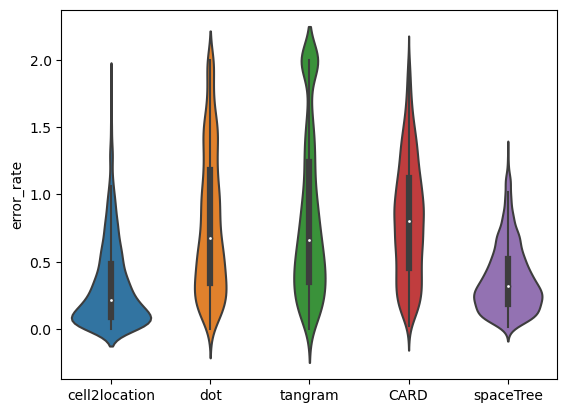

In [70]:
ax = sns.violinplot(data = dat)
ax.set_xticklabels(['cell2location','dot','tangram', "CARD", "spaceTree"])
ax.set_ylabel("error_rate")


In [73]:
dat.median()

error_rate_c2l        0.216909
error_rate_dot        0.675608
error_rate_tangram    0.659135
error_rate_card       0.802494
error_rate_st         0.320462
dtype: float64

In [74]:
mysty = pd.read_csv("../data/external/sigs_per_spot.csv", index_col = 0)

In [75]:
mysty

,intra_sigs,para_sigs
AACACTTGGCAAGGAA-1,438.25,482.25
AACAGGATTCATAGTT-1,450.75,492.50
AACAGGTTATTGCACC-1,451.25,493.00
AACAGGTTCACCGAAG-1,458.75,500.75
AACATCTAATGACCGG-1,422.50,495.75
...,...,...
TGTTGGAACCTTCCGC-1,442.50,487.50
TGTTGGAACGAGGTCA-1,443.75,481.25
TGTTGGAAGCTCGGTA-1,439.00,476.00
TGTTGGATGGACTTCT-1,445.25,491.25


In [76]:
visium.obs = visium.obs.join(mysty, on = "spot")

[<Axes: title={'center': 'intra_sigs'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'para_sigs'}, xlabel='spatial1', ylabel='spatial2'>]

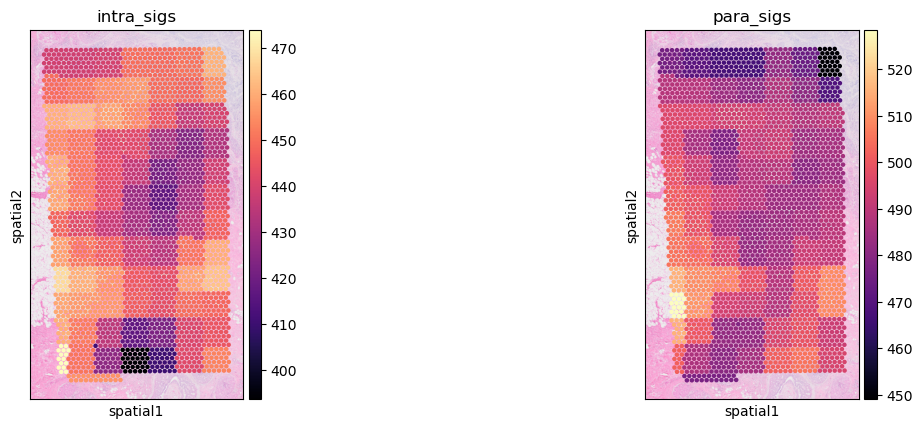

In [77]:
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color=["intra_sigs", "para_sigs"],
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  show=False
                 )

In [78]:
mysty = pd.read_csv("../data/external/sigs_per_spot2.csv", index_col = 0)

In [79]:
mysty

,intra_sigs,para_sigs
AACACTTGGCAAGGAA-1,469.00,502.00
AACAGGATTCATAGTT-1,481.50,497.25
AACAGGTTATTGCACC-1,483.00,514.75
AACAGGTTCACCGAAG-1,492.25,489.25
AACATCTAATGACCGG-1,449.25,473.50
...,...,...
TGTTGGAACCTTCCGC-1,468.50,492.50
TGTTGGAACGAGGTCA-1,477.25,499.00
TGTTGGAAGCTCGGTA-1,470.00,472.00
TGTTGGATGGACTTCT-1,471.75,492.00


In [80]:
visium.obs = visium.obs.drop(["intra_sigs", "para_sigs"], axis = 1)

In [81]:
visium.obs = visium.obs.join(mysty, on = "spot")

[<Axes: title={'center': 'intra_sigs'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'para_sigs'}, xlabel='spatial1', ylabel='spatial2'>]

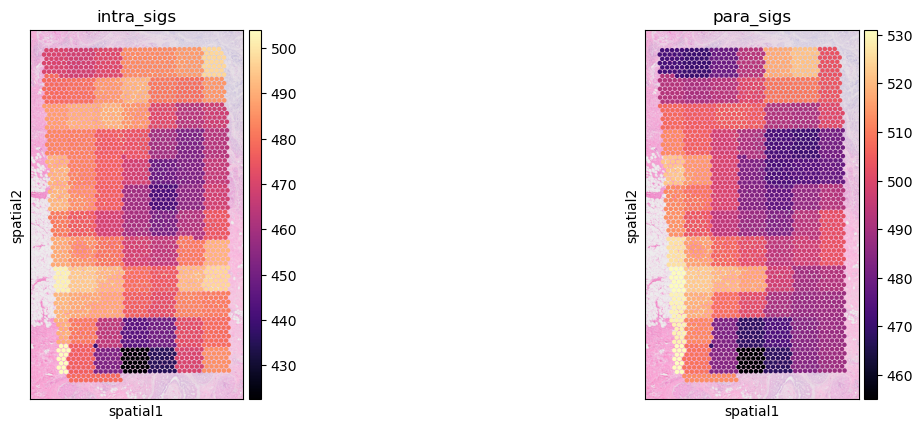

In [82]:
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color=["intra_sigs", "para_sigs"],
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  show=False
                 )

In [83]:
visium.obs["cell_type_mixture"] = rep1_ct.std(axis = 1)

In [84]:
visium.obs["cell_type_mixture"] 


spot_id
2       0.138290
4       0.170266
6       0.182293
7       0.181572
15      0.292538
          ...   
4986    0.333333
4987    0.333140
4988    0.213735
4989    0.211371
4990    0.194635
Name: cell_type_mixture, Length: 2829, dtype: float64

[<Axes: title={'center': 'cell_type_mixture'}, xlabel='spatial1', ylabel='spatial2'>]

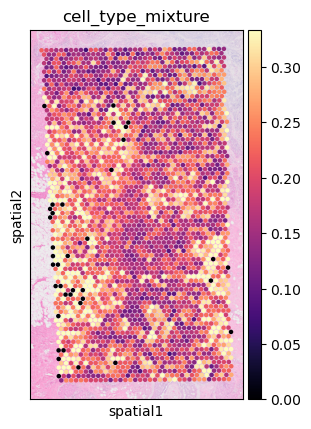

In [85]:
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color="cell_type_mixture",
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  show=False
                 )

<Axes: xlabel='para_sigs', ylabel='cell_type_mixture'>

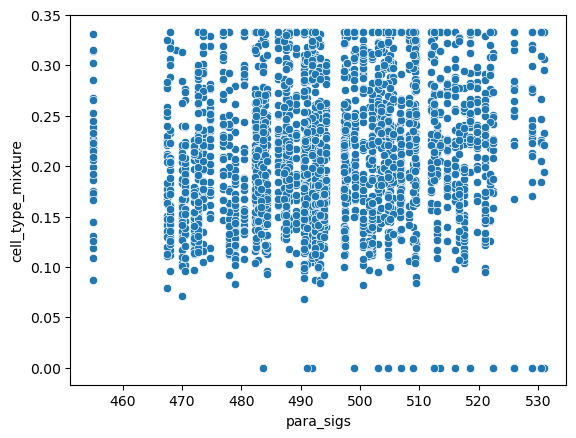

In [86]:
sns.scatterplot(x = visium.obs.para_sigs, y = visium.obs.cell_type_mixture)

<Axes: xlabel='intra_sigs', ylabel='cell_type_mixture'>

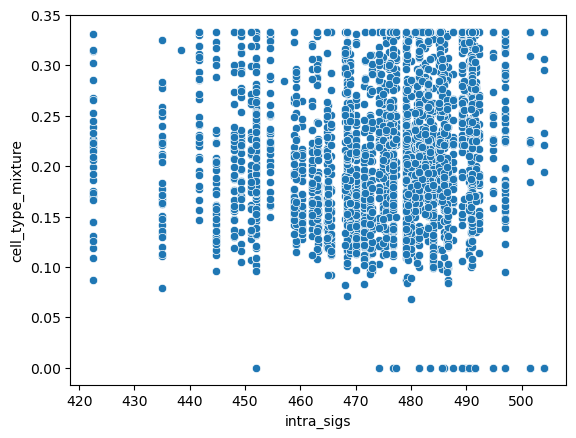

In [87]:
sns.scatterplot(x = visium.obs.intra_sigs, y = visium.obs.cell_type_mixture)

<Axes: xlabel='para_sigs', ylabel='error_rate_dot'>

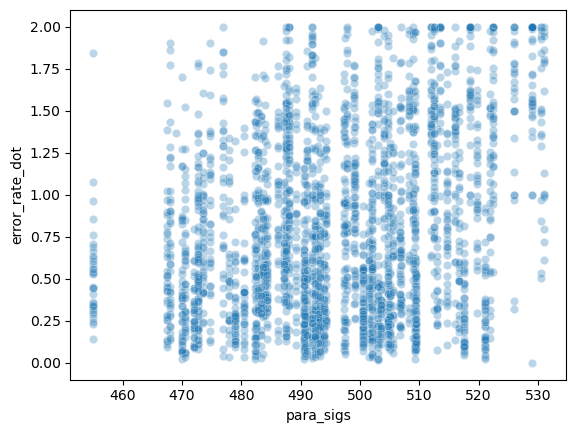

In [88]:
sns.scatterplot(x = visium.obs.para_sigs, y = visium.obs.error_rate_dot, alpha = 0.3)

<Axes: xlabel='para_sigs', ylabel='error_rate_card'>

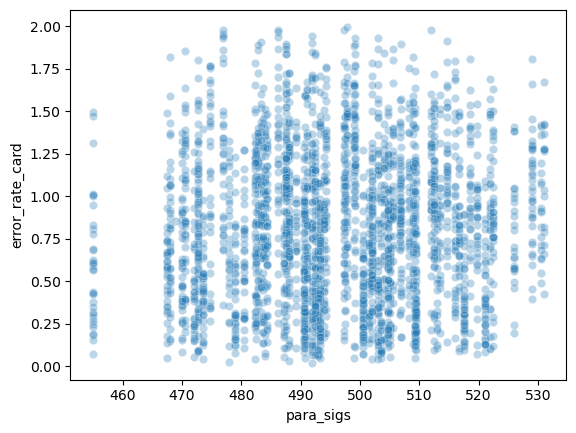

In [89]:
sns.scatterplot(x = visium.obs.para_sigs, y = visium.obs.error_rate_card, alpha = 0.3)

<Axes: xlabel='para_sigs', ylabel='error_rate_c2l'>

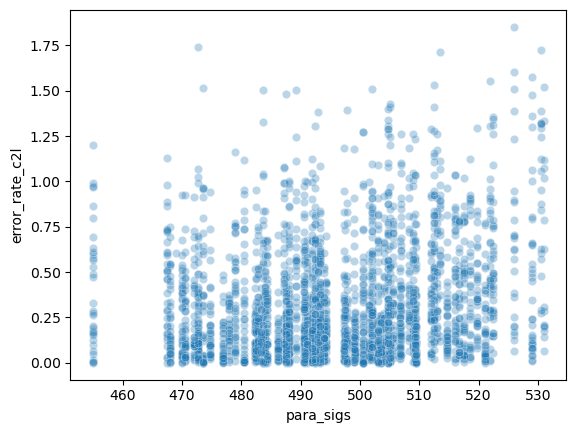

In [65]:
sns.scatterplot(x = visium.obs.para_sigs, y = visium.obs.error_rate_c2l, alpha = 0.3)

<Axes: xlabel='para_sigs', ylabel='error_rate_st'>

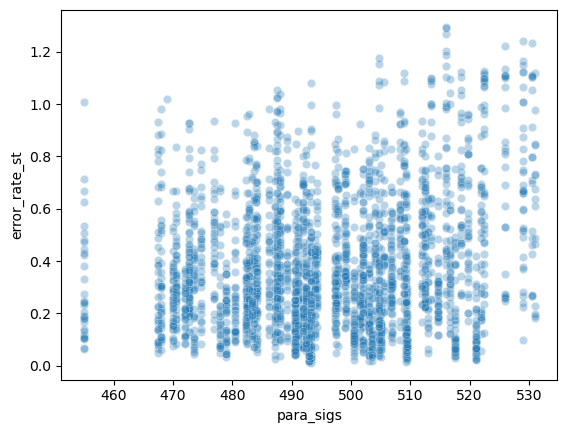

In [90]:
sns.scatterplot(x = visium.obs.para_sigs, y = visium.obs.error_rate_st, alpha = 0.3)

In [66]:
tmp = visium.obs[["para_sigs", "error_rate_dot"]]
tmp = tmp.dropna()

In [67]:
tmp

,para_sigs,error_rate_dot
spot_id,,
2,502.00,0.462796
4,497.25,0.544696
6,514.75,0.733981
7,489.25,0.460187
15,473.50,0.573389
...,...,...
4986,492.50,1.548485
4987,499.00,1.545517
4988,472.00,0.096044


In [68]:
# measure correlation
np.corrcoef(tmp.para_sigs, tmp.error_rate_dot)

array([[1.        , 0.27626693],
       [0.27626693, 1.        ]])

In [69]:
tmp = visium.obs[["para_sigs", "error_rate_c2l"]]
tmp = tmp.dropna()

In [70]:
np.corrcoef(tmp.para_sigs, tmp.error_rate_c2l)

array([[1.        , 0.20149185],
       [0.20149185, 1.        ]])

<Axes: xlabel='para_sigs', ylabel='error_rate_st'>

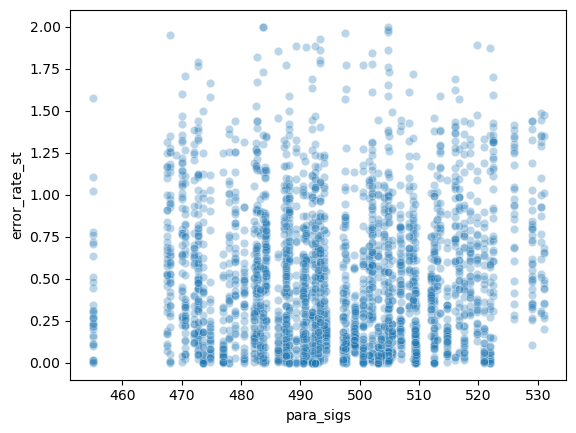

In [71]:
sns.scatterplot(x = visium.obs.para_sigs, y = visium.obs.error_rate_st, alpha = 0.3)